# DOĞUŞ DATATHON

## Kaggle Requirements

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dogus-teknoloji-n11
!unzip train_n11.csv.zip -d sample_data
!unzip test_n11.csv.zip -d sample_data

## Importing necesary libraries

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
#Preproccesing
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import numpy as np

# Evaluation Metrics
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn import metrics

# Tensorlow Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, Dropout, Activation, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import load_model, Model, Sequential
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import layers, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# NLP processes
import re
import nltk
import string
from nltk.tokenize import RegexpTokenizer

## Data Preprocessing

### Reading the data and checking the classes

#### TRAIN DATA

In [ ]:
data = pd.read_csv('sample_data/train_n11.csv', sep='|')
data.head()

,ID,TITLE,DESCRIPTION,CATEGORY_ID
0,46715,Sonia SN-X60 Kulak Üstü Oyuncu Kulaklık,<style>\n .uni-content {\n font-fami...,1000365
1,77151,ABC Power Sıvı Bulaşık Deterjanı 1370 G,<style>\n .uni-content {\n font-fami...,1001377
2,91464,Einhell TE-CD 18/2 Li 18V 2.5 Ah Li-ion Akülü ...,<style>\n .uni-content {\n font-fami...,1001527
3,53057,Arzum AR4095 Olimpia Smart Cyclone 899 W Filtr...,"<meta name=""viewport"" content=""width=device-wi...",1000420
4,73951,Pedigree Biftekli ve Kümes Hayvanlı Yetişkin K...,<style>\n .uni-content {\n font-fami...,1000958


In [ ]:
data.drop(['DESCRIPTION', 'ID'], axis=1, inplace=True)
data.head()

,TITLE,CATEGORY_ID
0,Sonia SN-X60 Kulak Üstü Oyuncu Kulaklık,1000365
1,ABC Power Sıvı Bulaşık Deterjanı 1370 G,1001377
2,Einhell TE-CD 18/2 Li 18V 2.5 Ah Li-ion Akülü ...,1001527
3,Arzum AR4095 Olimpia Smart Cyclone 899 W Filtr...,1000420
4,Pedigree Biftekli ve Kümes Hayvanlı Yetişkin K...,1000958


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Label')

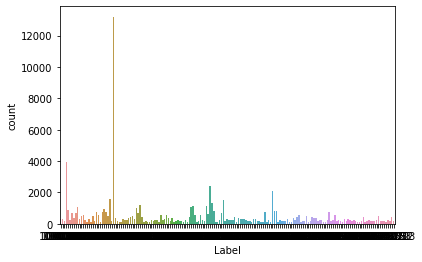

In [ ]:
sns.countplot(data.CATEGORY_ID)
plt.xlabel('Label')

#### TEST DATA

In [ ]:
test = pd.read_csv('sample_data/test_n11.csv', error_bad_lines=False, sep='|')
test.drop(['DESCRIPTION', 'ID'], axis=1, inplace=True)

test.head()

,TITLE,CATEGORY_ID
0,Gimcat Tahılsız Mint Tips Naneli Şekersiz Kedi...,NaN
1,Doğadan Şifalı Bitkiler Adaçayı Bardak Poşet 3...,NaN
2,Dell Precision M3551.P5 i5-10300H 64 GB RAM 1 ...,NaN
3,Prima Premium Care Bebek Bezi 2 Beden 60'lı,NaN
4,Hyundai HRS710 Tilki Kuyruğu Testere Elektrikl...,NaN


### NLP Processes

In [ ]:
# TO LOWERCASE
data['TITLE'] = data['TITLE'].str.lower()
test['TITLE'] = test['TITLE'].str.lower()


# REMOVING PUNCTUATIONS
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)


data['TITLE']= data['TITLE'].apply(lambda x: cleaning_punctuations(x))
test['TITLE']= test['TITLE'].apply(lambda x: cleaning_punctuations(x))



# CLEANING NUMERIC DATA
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)

data['TITLE'] = data['TITLE'].apply(lambda x: cleaning_numbers(x))
test['TITLE'] = test['TITLE'].apply(lambda x: cleaning_numbers(x))

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')
data['TITLE'] = data['TITLE'].apply(tokenizer.tokenize)
data['TITLE'].head()

0          [sonia, snx, kulak, üstü, oyuncu, kulaklık]
1            [abc, power, sıvı, bulaşık, deterjanı, g]
2    [einhell, tecd, li, v, ah, liion, akülü, matka...
3    [arzum, ar, olimpia, smart, cyclone, w, filtre...
4    [pedigree, biftekli, ve, kümes, hayvanlı, yeti...
Name: TITLE, dtype: object

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')
test['TITLE'] = test['TITLE'].apply(tokenizer.tokenize)
test['TITLE'].head()

0    [gimcat, tahılsız, mint, tips, naneli, şekersi...
1    [doğadan, şifalı, bitkiler, adaçayı, bardak, p...
2    [dell, precision, mp, ih, gb, ram, tb, ssd, gb...
3       [prima, premium, care, bebek, bezi, beden, lı]
4    [hyundai, hrs, tilki, kuyruğu, testere, elektr...
Name: TITLE, dtype: object

In [ ]:
max_fatures = 3000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['TITLE'].values)
X = tokenizer.texts_to_sequences(data['TITLE'].values)
X = sequence.pad_sequences(X)
print(X[:2])

max_len = 31

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0  45 117  79  52]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0 565 208 200  97 112   5]]


In [ ]:
X_testset = tokenizer.texts_to_sequences(test['TITLE'])
X_testset = sequence.pad_sequences(X_testset,maxlen=31)
print(X_testset[:2])

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0  445  129 1763   10
   333    2    5]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0  376  539
   370    2   41]]


In [ ]:
Y = data['CATEGORY_ID']
label_encoder = LabelEncoder()
encod_y = label_encoder.fit_transform(Y)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,encod_y, test_size = 0.20, random_state = 42)

## MODEL TRAINING

In [ ]:
def tensorflow_based_model():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(3000,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(177,name='out_layer')(layer)
    layer = Activation('softmax')(layer)
    model = Model(inputs=inputs,outputs=layer) 
    return model

In [ ]:
# Training the model
model = tensorflow_based_model() 
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy()
,optimizer=Adam(),metrics=['accuracy'])
model.summary()
history=model.fit(X_train,Y_train,batch_size=80,epochs=10, validation_split=0.1)


# Starting to test the model here
accr1 = model.evaluate(X_test,Y_test)
print('Test set\n  Accuracy: {:0.2f}'.format(accr1[1])) 

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 31)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 31, 50)            150000    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
____________________________________________________________

## RESULTS

In [ ]:
final_pred = model.predict(X_testset)

In [ ]:
doga = []

for merve in final_pred:
  doga = np.append(doga, encod_y[np.argmax(merve)])

## SUBMISSION

In [ ]:
sub = pd.read_csv("sample_submission_n11.csv")
sub.drop('Expected',axis=1, inplace = True)
sub.head()

,ID
0,110350
1,90497
2,30915
3,4692
4,95918


In [ ]:
Y_class = data['CATEGORY_ID'].unique()
sorted = np.sort(Y_class)

In [ ]:
sub_prediction = []

for x in final_pred:
  sub_prediction = np.append(sub_prediction,sorted[np.argmax(x)])

In [ ]:
print(sub_prediction)

[1153150. 1001524. 1000271. ... 1000368. 1000271. 1000476.]


In [ ]:
sub_prediction.reshape(-1,1)

array([[1153150.],
       [1001524.],
       [1000271.],
       ...,
       [1000368.],
       [1000271.],
       [1000476.]])

In [ ]:
sub['Expected'] = sub_prediction

In [ ]:
sub

,ID,Expected
0,110350,1153150.0
1,90497,1001524.0
2,30915,1000271.0
3,4692,1000037.0
4,95918,1001677.0
...,...,...
20448,74187,1000958.0
20449,59227,1000479.0
20450,47338,1000368.0
20451,30573,1000271.0


In [ ]:
lstm_final = sub.to_csv('submission4.csv',encoding='utf-8',index= False)